# ⚡ Project 2: Site Energy Intensity Prediction

🧾**Description:** According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition was responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. 

The dataset consists of building characteristics, weather data for the location of the building, as well as the energy usage for the building, and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to a single building observed in a given year.

source of dataset & data dictionary - Click Here  

🧭 **Problem Statement:** You are provided with two datasets: (1) the train_dataset where the observed values of the Site EUI for each row are provided and (2) the x_test dataset the observed values of the Site EUI for each row are removed and provided separately in y_test. Your task is to predict the Site EUI for each row (using the complete training dataset), given the characteristics of the building and the weather data for the location of the building. Use the test sets for validation and testing. 

The target variable is **site_eui** and the evaluation metric is **RMSE** score.


In [2]:
import pandas as pd
import numpy as np
from IPython.display import display_html
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import joblib
from category_encoders import TargetEncoder

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import optuna
import tqdm
import shap

In [3]:
train = pd.read_csv('data/train_dataset.csv')
test = pd.read_csv('data/x_test.csv')

In [4]:
df_train = train.copy()
df_test = test.copy()

In [5]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [6]:
display_html(df_train.head(2), df_train.head(2), df_train.sample(2))

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
34309,4,State_6,Residential,Multifamily_Uncategorized,61750.0,1927.0,14.0,3.4,4,28.596774,...,75,4,0,0,1.0,1.0,1.0,NaN,142.927024,34309
10166,6,State_2,Residential,Multifamily_Uncategorized,128000.0,2005.0,17.0,32.9,11,32.000000,...,109,38,0,0,NaN,NaN,NaN,NaN,49.305778,10166


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [8]:
df_train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

# df.columns = df.columns.values.lower()

# EDA

year_Factor: anonymized year in which the weather and energy usage factors were observed  

state_Factor: anonymized state in which the building is located  

building_class: building classification  

facility_type: building usage type  

floor_area: floor area (in square feet) of the building  

year_built: year in which the building was constructed  

energy_star_rating: the energy star rating of the building  

elevation: elevation of the building location  

january_min_temp: minimum temperature in January (in Fahrenheit) at the location of the building  

january_avg_temp: average temperature in January (in Fahrenheit) at the location of the building  

january_max_temp: maximum temperature in January (in Fahrenheit) at the location of the building  

[Similarly for all other months]

cooling_degree_days: cooling degree day for a given day is the number of degrees where the daily average temperature   
exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

heating_degree_days: heating degree day for a given day is the number of degrees where the daily average temperature   falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

precipitation_inches: annual precipitation in inches at the location of the building  

snowfall_inches: annual snowfall in inches at the location of the building  

snowdepth_inches: annual snow depth in inches at the location of the building  

avg_temp: average temperature over a year at the location of the building  

days_below_30F: total number of days below 30 degrees Fahrenheit at the location of the building  

days_below_20F: total number of days below 20 degrees Fahrenheit at the location of the building  

days_below_10F: total number of days below 10 degrees Fahrenheit at the location of the building  

days_below_0F: total number of days below 0 degrees Fahrenheit at the location of the building  

days_above_80F: total number of days above 80 degrees Fahrenheit at the location of the building  

days_above_90F: total number of days above 90 degrees Fahrenheit at the location of the building  

days_above_100F: total number of days above 100 degrees Fahrenheit at the location of the building  

days_above_110F: total number of days above 110 degrees Fahrenheit at the location of the building  

direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

max_wind_speed: maximum wind speed at the location of the building  

days_with_fog: number of days with fog at the location of the building  

building_id: building id  

#### Target

**site_eui:** Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills 

In [9]:
numerical_feature = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df_train[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df_train.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 61
Discrete feature Count 6
Continuous feature Count 55
Categorical feature Count 3


In [10]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [11]:
print([col for col in df_train if df_train[col].nunique()==1])
print([col for col in df_test if df_test[col].nunique()==1])

[]
['year_factor', 'days_above_110F']


In [12]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.500000
direction_peak_wind_speed,41811,55.200000
direction_max_wind_speed,41082,54.200000
max_wind_speed,41082,54.200000
energy_star_rating,26709,35.300000
year_built,1837,2.400000


In [14]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,9117,93.900000
direction_max_wind_speed,8575,88.400000
direction_peak_wind_speed,8575,88.400000
max_wind_speed,8575,88.400000
energy_star_rating,2254,23.200000
year_built,92,0.900000


<div style="border-radius:10px; border:#91C7B1 solid; padding: 15px; background-color: #f1f7ed; font-size:100%; text-align:left">
<h3 align="left"><font color='#91C7B1'>💡 Observations:</font></h3>

1) `year_built`, `energy_star_rating`, `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, `days_with_fog` variables have `NA` values.   
2) Data contains 75757 samples and 64 features. We have 3 categorical and rest numerical features. Target is numerical.   
3) There are no duplicates in individual dataset, however there might be duplicates in the combined version   
4) there are no constant columns in train dataset, but test dataset has 2 constant columns   

In [15]:
test['site_eui'] = np.nan #63
test['dataset'] = 'test'
train['dataset'] = 'train'


# train = commondf["dataset"]  == "train"

df_all = pd.concat([train, test], axis=0, ignore_index=True)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    The dataset contains time variable, `Year_Factor`, that has values from 1 to 7. Assuming the values are consecutive years,`train` dataset contains the first 6 years and `test` set contains the 7th year.</div>

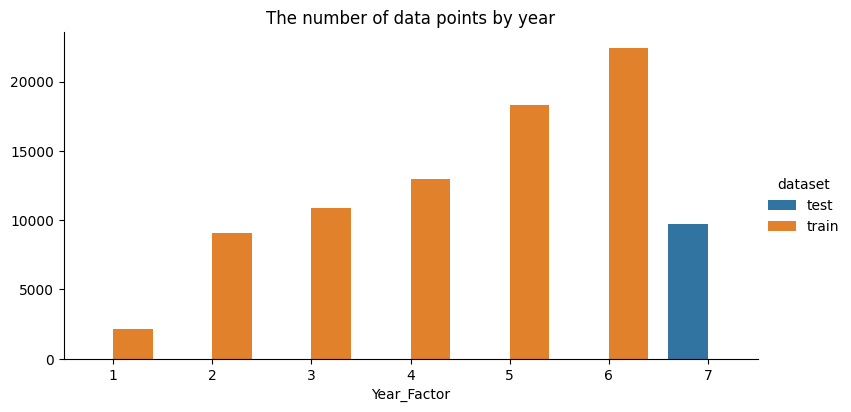

In [16]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

# encoded (morphed) value of original year

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`train` set contains data points of 7 states, however, `test` doesn't have any data point from `State_6`.</div>

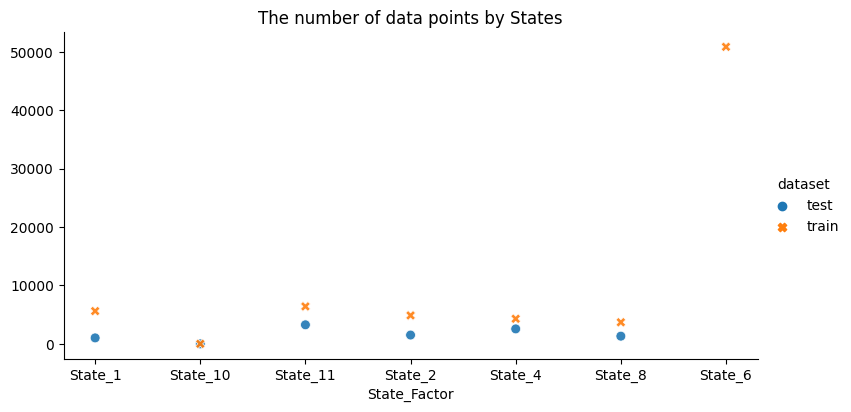

In [17]:
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

In [18]:
df_test["state_factor"].unique()

array(['State_1', 'State_2', 'State_4', 'State_8', 'State_11', 'State_10'],
      dtype=object)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Both residential and commercial buildings are present in both datasets. `train` data contains more residential buildings compared to `test` set which is due to the number of`State_6` buildings in `train` set which seems to add to the number. Apart from `State_6`, the number of commercial buildings are higher than the residential buildings and `State_10` only contains commercial buildings. The type of building and state could be important factors in determining `EUI`.</div>

Text(0.5, 0, '')

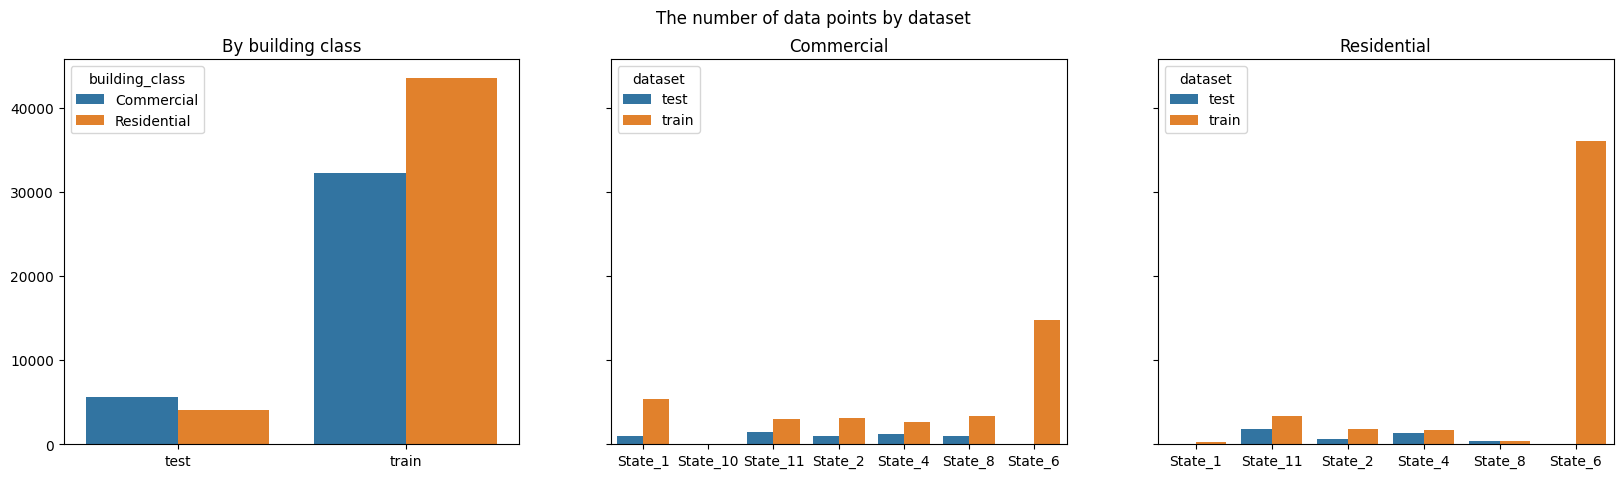

In [19]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            errorbar=None)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                errorbar=None)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">All facility types are present in both datasets. Almost 90% of residential `Multifamily_uncategorized` buildings and 50% of `Office_uncategorized` are in `State_6` of the training set. Not quite sure how `State_6` will affect the model learning and prediction.</div>

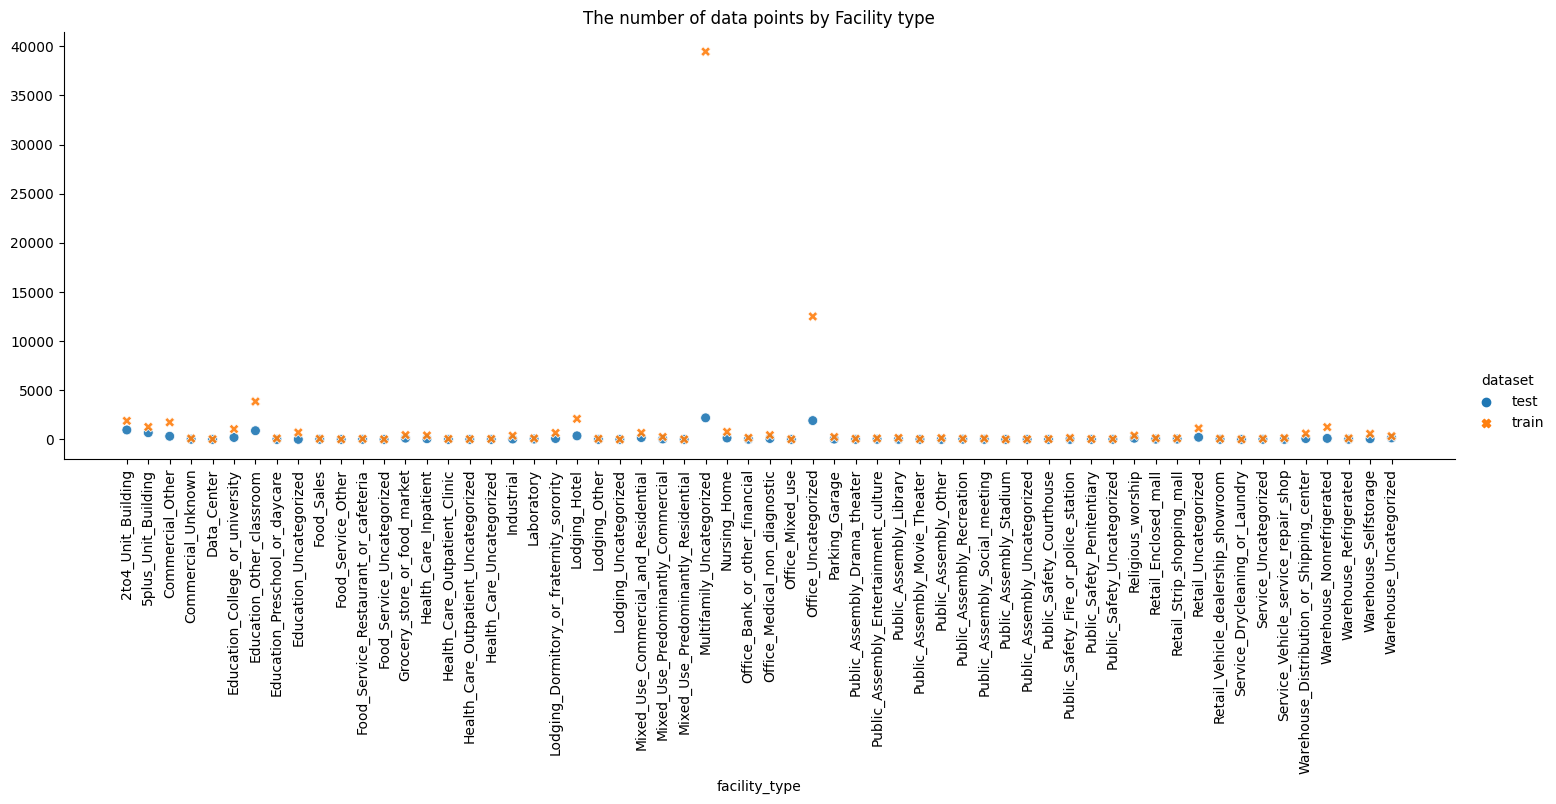

In [20]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">The oldest building was built in 1600 and the latest in 2016. The majority of the buildings were built since 1900. There were some 0 and null values. Not quite sure what 0 signifies.</div>

In [21]:
df_all['year_built'].value_counts().index.sort_values()

Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0, 1811.0,
       1815.0,
       ...
       2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0,
       2016.0],
      dtype='float64', name='year_built', length=183)

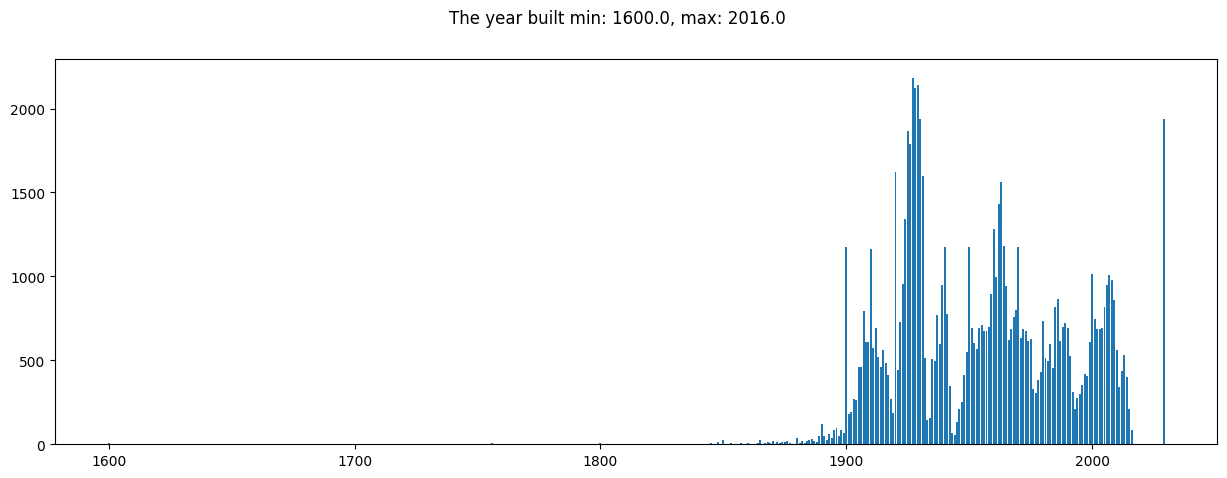

In [22]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')
# temp['year_built'] = temp['year_built'].astype('category')
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`train` set buildings have higher floor areas compared to `test` set buildings and small positive correlation between `floor_area` and `energy_star_rating` can be observable. </div>

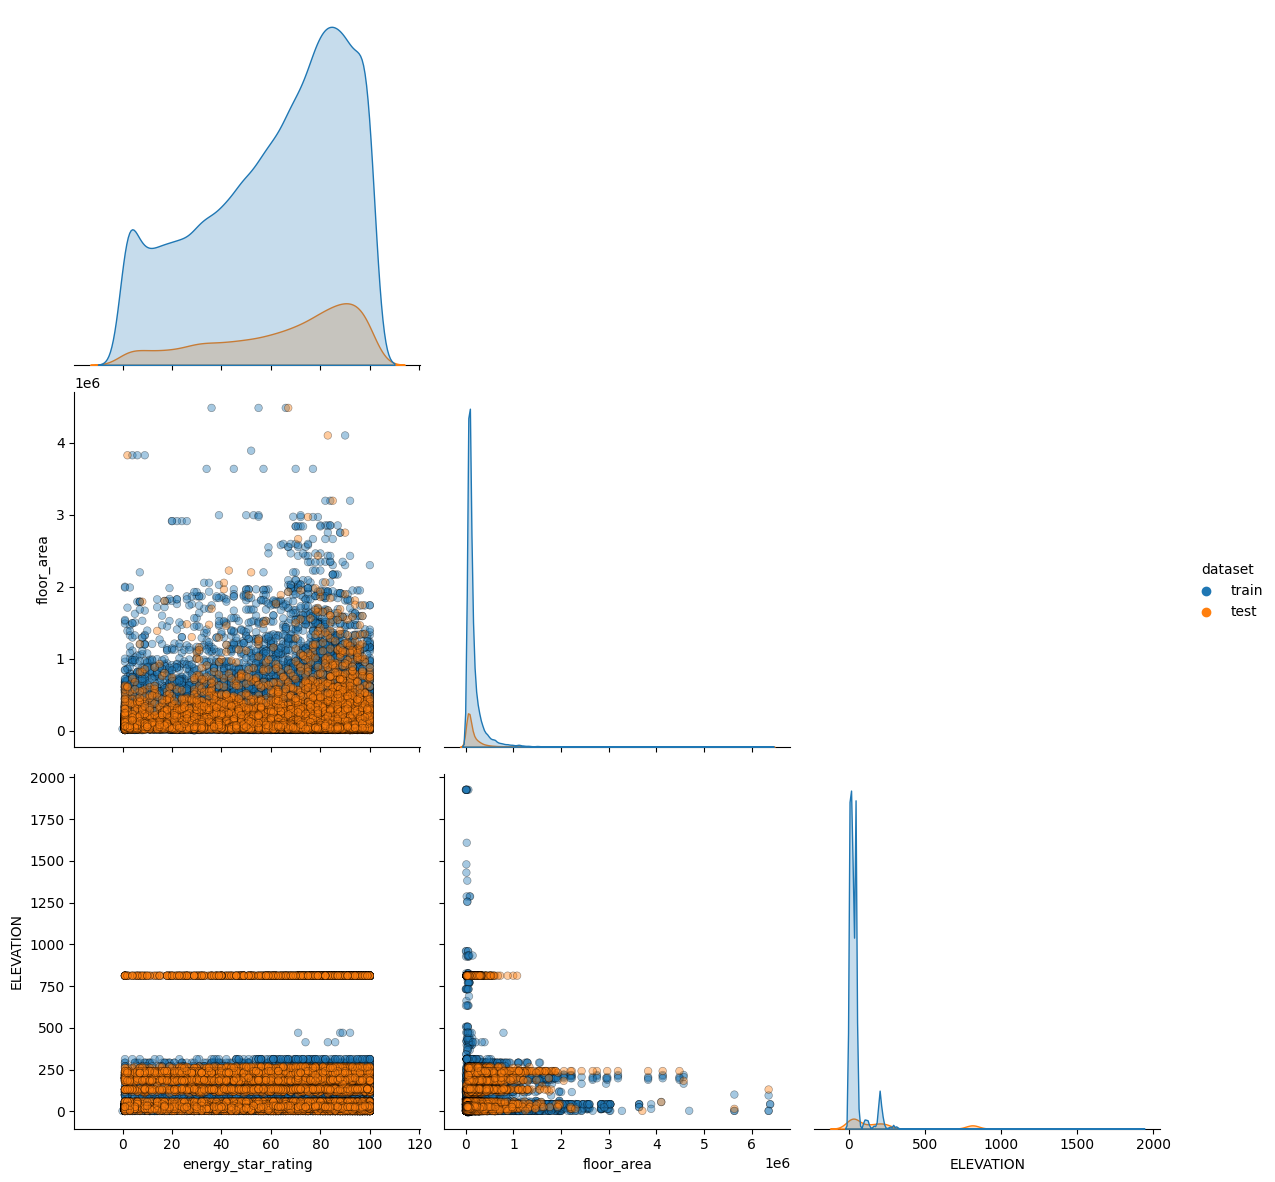

In [23]:
sns.pairplot(df_all,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           );

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">According to the average temperature (`avg_temp`), if we list states from warmest to coldest: State 1, State 10, State 2, and State 8. The range of temperatures of State1, State 6,  State 11 and State 4 are higher compared to the other states. </div>

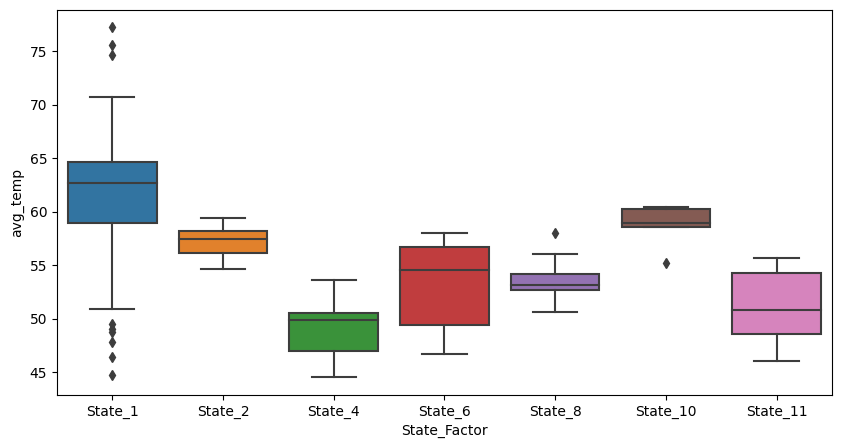

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');


# any one categorical col (with low unique vals)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Each month has unique temperature values between 31 and 59 which means the values in temperature volumes are highly repeated for the data points.</div>

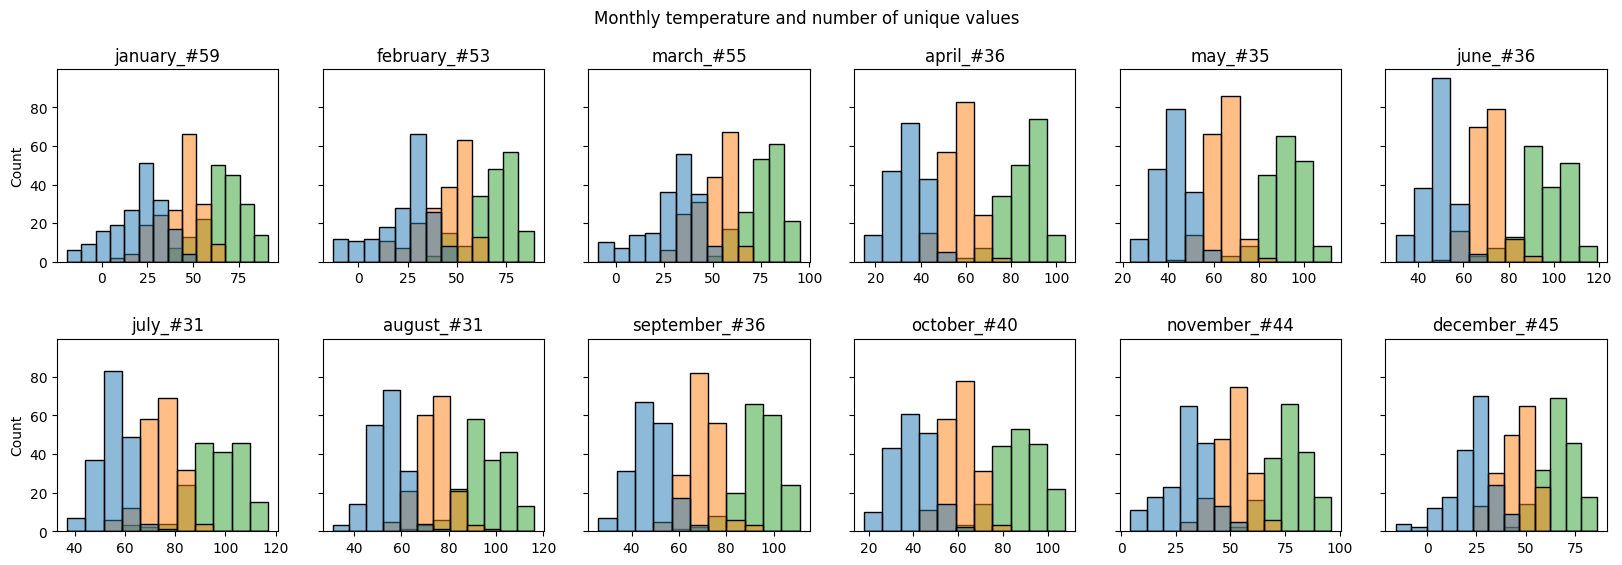

In [25]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Other weather related numerical columns also have few unique values.</div>

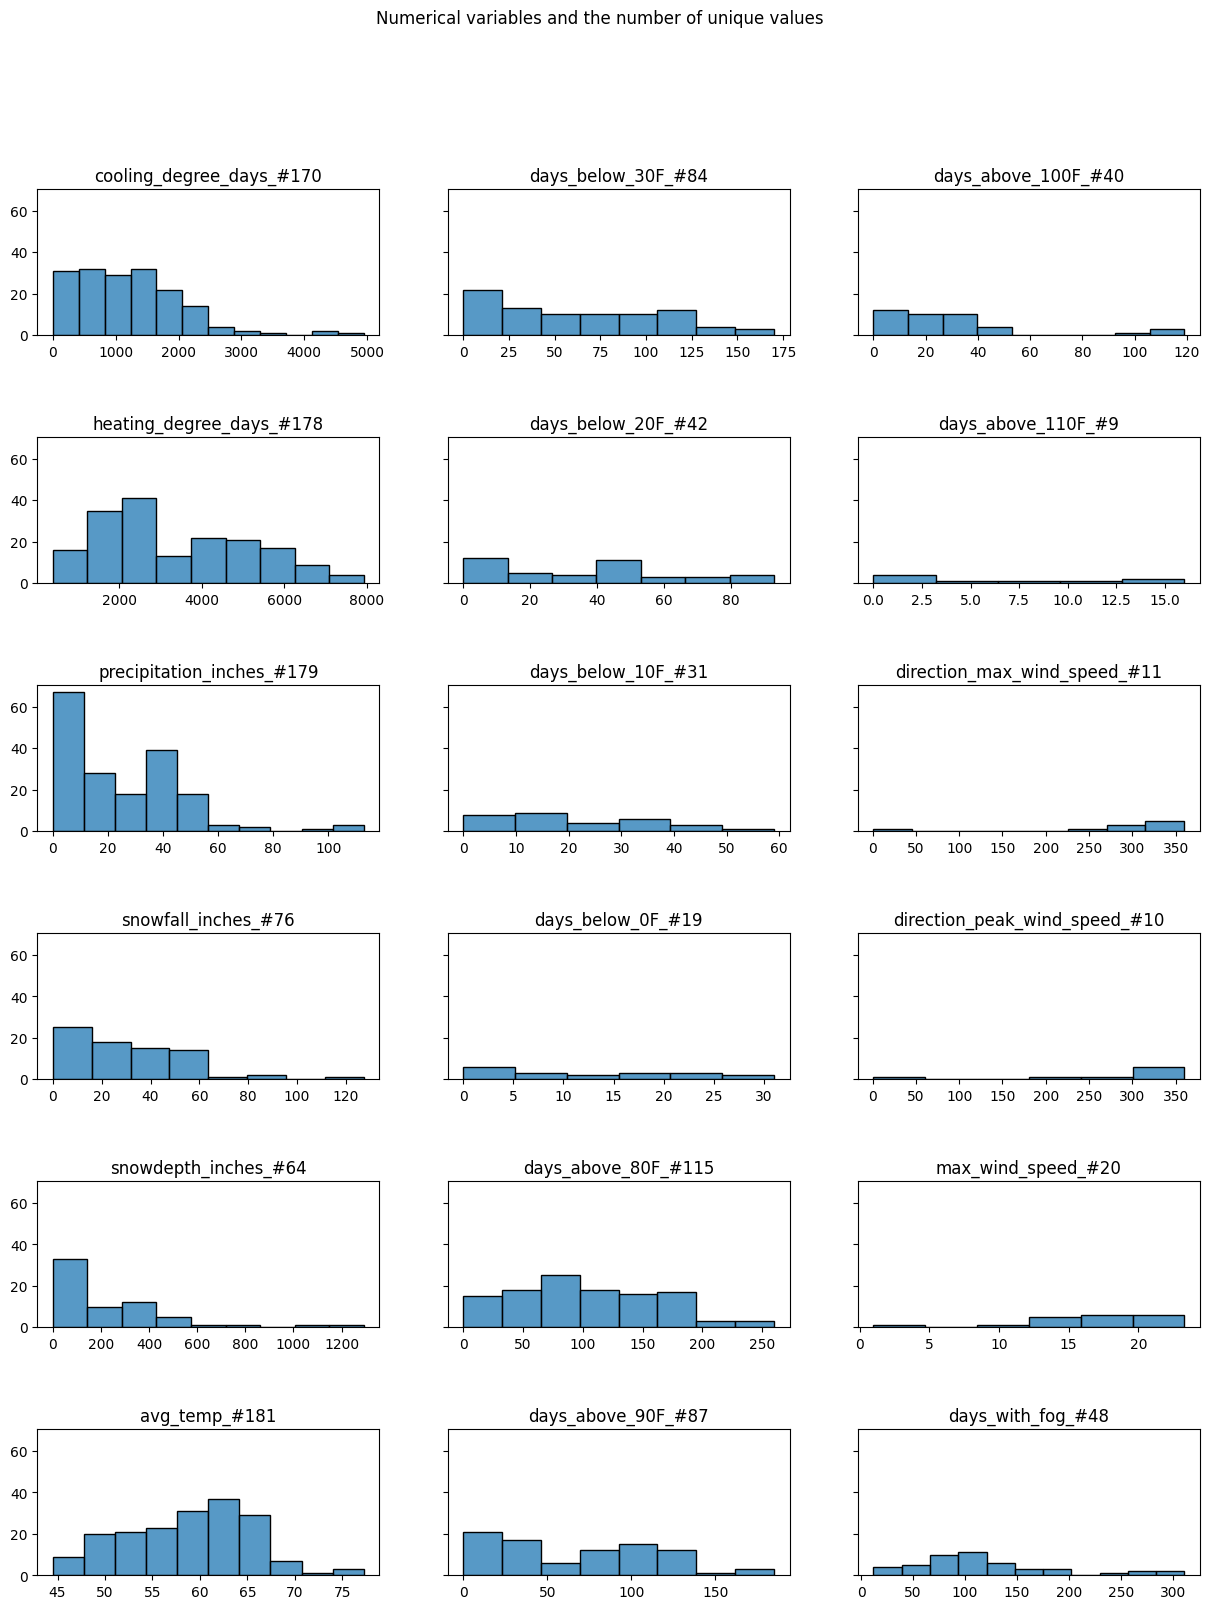

In [26]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

### 📌Target Variable Exploration (EUI)

Ignoring `palette` because no `hue` variable has been assigned.


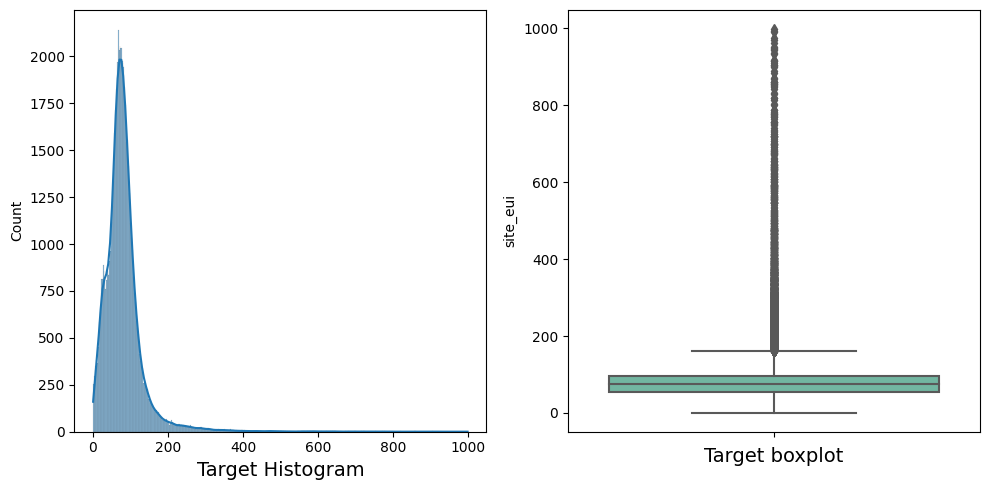

In [27]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">State 2 and 4 have slightly higher EUI and State 11 and 8 have lower EUI level.</div>

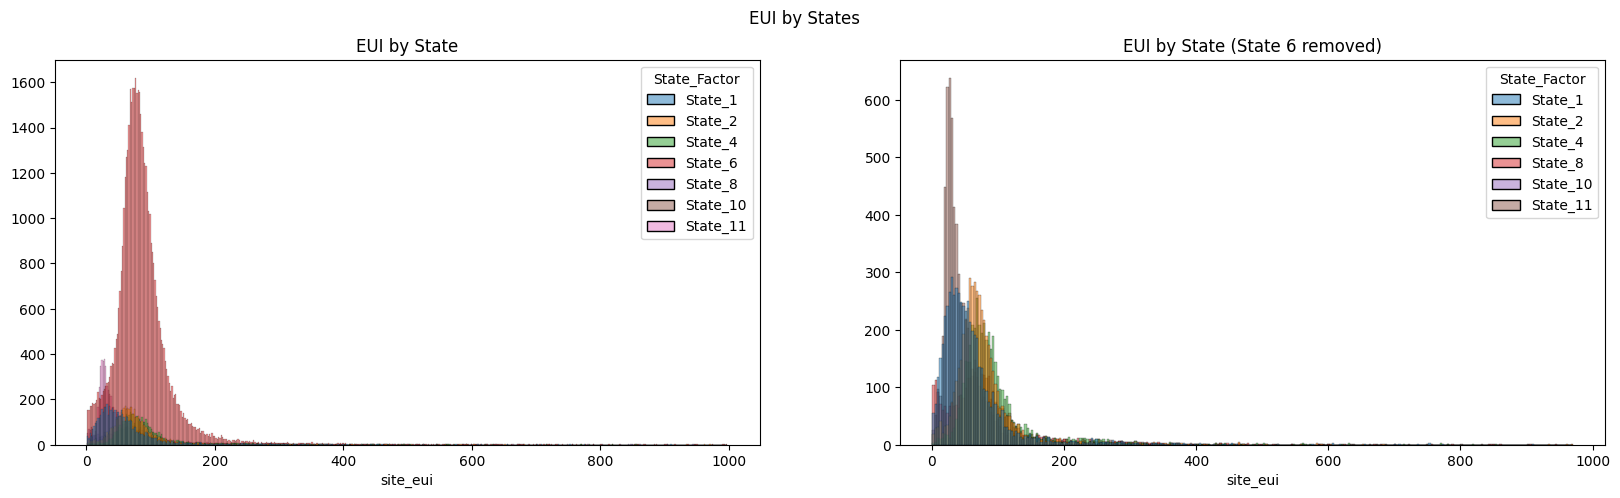

In [28]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

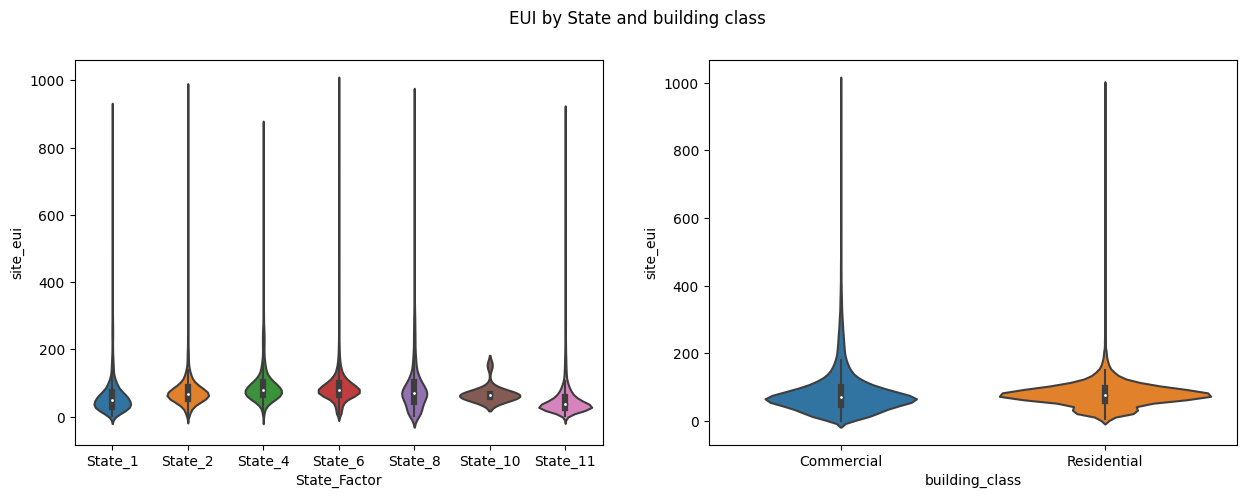

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.violinplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=df_all, y='site_eui', x='building_class', ax=ax[1]);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Labs and Data Centers have higher EUI compared to the other types of buildings. Grocery stores, Health Care Inpatient, Health Care Uncategorized, Health Care Outpatient, and Food service, restaurants have higher range of EUI. It could be the essential services must operate for longer hours, therefore, have higher EUI.</div>

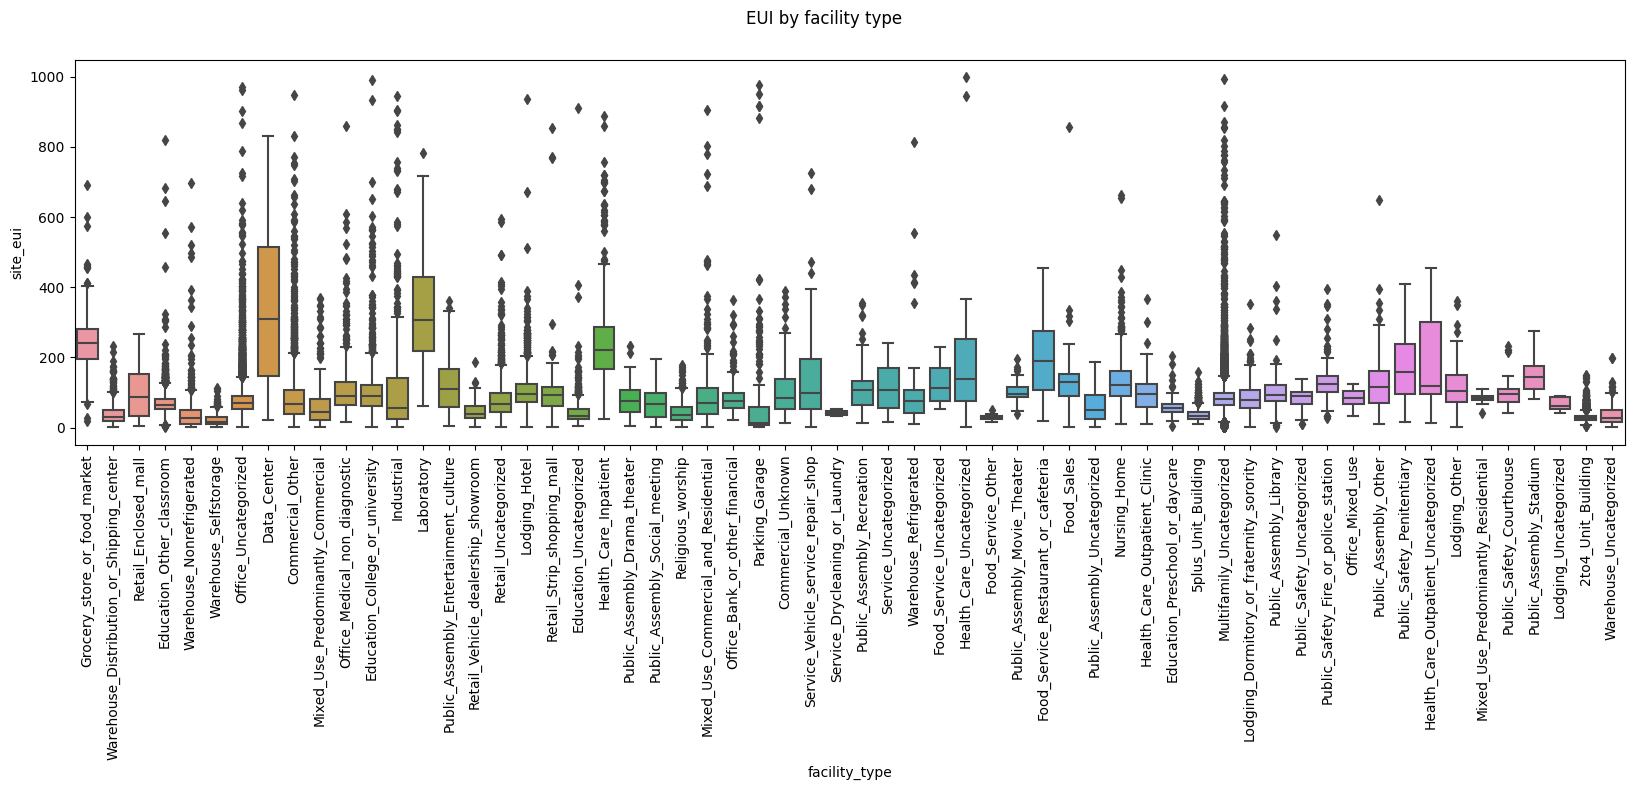

In [30]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`floor_area` could have positive relationship with `EUI`. The younger buildings tend to have higher `EUI` which could be because building height and size have increased over the years. It looks like the Higher the `energy_star_rating` is, the lower the `EUI` becomes.</div>

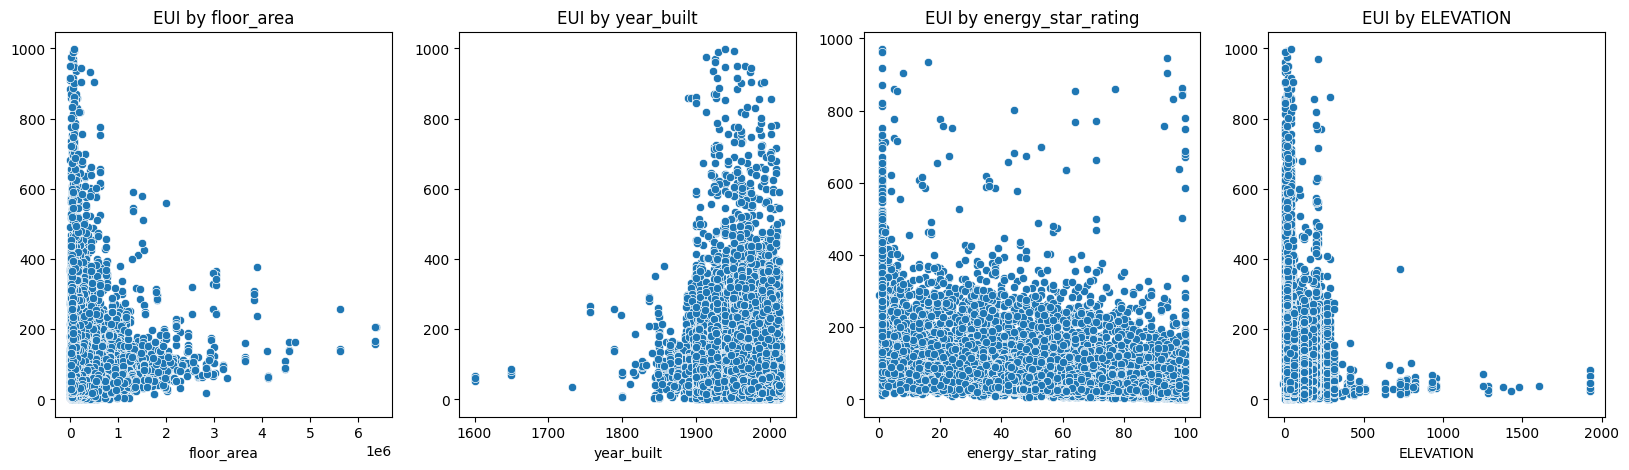

In [31]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">The most data points are in lower number of `cooling_degree_days` and higher number of`heating_degree_days`. The majority of the datapoints are also in the lower levels of `snowfall_inches` and `snowdepth_inches`. `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, and `days_with_fog` columns have the `NA` values of over 50%. No relationship between `EUI` and the weather related numerica columns can be observed from the plot.</div>

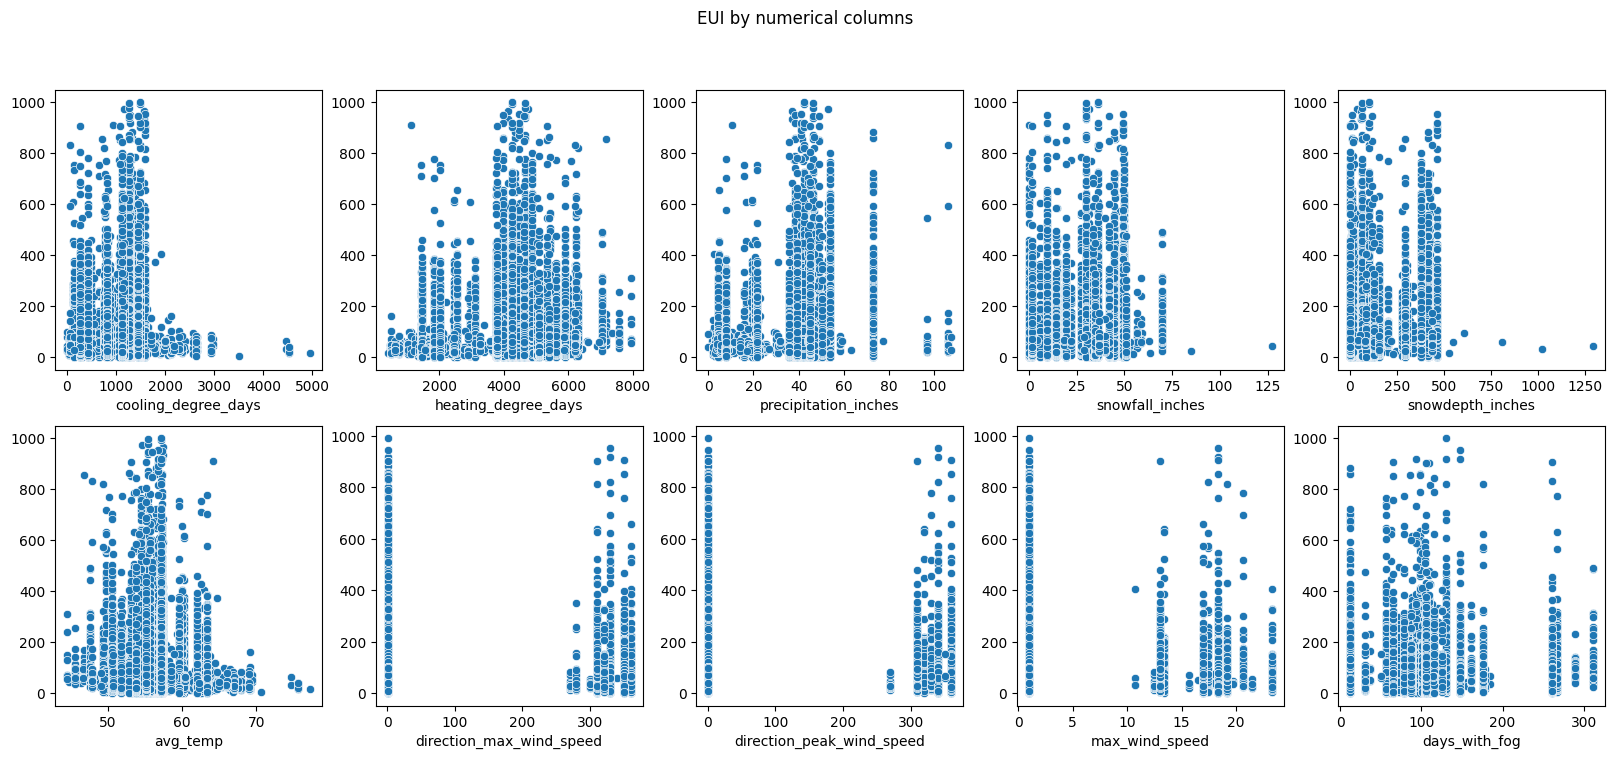

In [32]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

<div style="border-radius:10px; border:#91C7B1 solid; padding: 15px; background-color: #f1f7ed; font-size:100%; text-align:left">
<h3 align="left"><font color='#91C7B1'>💡 Observations:</font></h3>

- Categorical variables such as `State_Factor`, `building_class` and `facility_type` might have some correlation with `EUI`.
- `State_6` is not present in `test` set. State 6 removed training data should be tested.
- `floor_area`, `energe_star_rating` should be included in the modelling to be tested.
- From the plots, it's difficult to observe direct (linear) relationship between `EUI` and weather related variables. However, this doesn't deny non-linear relationships among the variables.
- Variables with more than 50% `NA` values should not be imputed (in my opinion) and better to be not included in the training set.
- Weather variables have few unique values repeated throughout the datapoints. Not sure how this duplicated values might affect the modeling and prediction. 

# ⚙️ Preprocessing



<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    we will suppose that two  if two buildings have the same values for these features;   
they are the same building, in other words groupby_cols = (building_id)


Removing duplicates by clubbing similar building data
</div>

In [33]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [34]:
df_all.loc[:,df_all.dtypes=='object'].columns
# State_Factor	building_class	facility_type

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    Null imputation for categorical values: <b>KNN Imputing</b>
</div>

In [35]:
df_all_one_hot = df_all.copy()

cats = ['State_Factor', 'facility_type', 'building_class', 'dataset']
for col in cats:
    dummies = pd.get_dummies(df_all_one_hot[col], dummy_na=False)
    for ohe_col in dummies:
        df_all_one_hot[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [36]:
df_all_one_hot.head(2)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,ohe_facility_type_Service_Vehicle_service_repair_shop,ohe_facility_type_Warehouse_Distribution_or_Shipping_center,ohe_facility_type_Warehouse_Nonrefrigerated,ohe_facility_type_Warehouse_Refrigerated,ohe_facility_type_Warehouse_Selfstorage,ohe_facility_type_Warehouse_Uncategorized,ohe_building_class_Commercial,ohe_building_class_Residential,ohe_dataset_test,ohe_dataset_train
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,...,False,False,False,False,False,False,True,False,False,True
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,...,False,False,False,False,False,False,True,False,False,True


In [37]:
# This takes 1 hr, hence, unpickle the df1 and carry on with knn_imputing = False

knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    tmp.to_csv('data/imputer_tmp.csv', index=False)
    df1.to_csv('data/imputer_df1.csv', index=False)
    joblib.dump(imputer, 'data/knn_imputer.pkl')

else:
    df1 = pd.read_csv('data/imputer_df1.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]


# df1: no null values
# tmp: seperated columns
#     df1 + tmp  => final df



# null points  => neighbours (most gets imputed)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    <b>Target encoding</b> for categorical columns.  
Target encoding is the process of replacing a categorical value with the mean of the target variable. Any non-categorical columns are automatically dropped by the target encoder model.

Note: You can also use target encoding to convert categorical columns to numeric. 

> “features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.”

[Target Encoding Vs. One-hot Encoding with Simple Examples](https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64)
<div>

In [38]:
df_all_te = df_all.copy()

cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all_te[f'te_{col}'] = encoder.fit_transform(df_all_te[col], df_all_te[target])

# Feature Engineering

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    <font size='3.5pt'><b>Weather based features</b></font>

we will extract new weather statistics from the building location weather features

In [39]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all_te.columns if 'temp' in col]

df_all_te['min_temp'] = df_all_te[temp].min(axis=1)
df_all_te['max_temp'] = df_all_te[temp].max(axis=1)
df_all_te['avg_temp'] = df_all_te[temp].mean(axis=1)
df_all_te['std_temp'] = df_all_te[temp].std(axis=1)
df_all_te['skew_temp'] = df_all_te[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in df_all_te.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all_te['min_winter_temp'] = df_all_te[winter_temp].min(axis=1)
df_all_te['max_winter_temp'] = df_all_te[winter_temp].max(axis=1)
df_all_te['avg_winter_temp'] = df_all_te[winter_temp].mean(axis=1)
df_all_te['std_winter_temp'] = df_all_te[winter_temp].std(axis=1)
df_all_te['skew_winter_temp'] = df_all_te[winter_temp].skew(axis=1)
### spring
df_all_te['min_spring_temp'] = df_all_te[spring_temp].min(axis=1)
df_all_te['max_spring_temp'] = df_all_te[spring_temp].max(axis=1)
df_all_te['avg_spring_temp'] = df_all_te[spring_temp].mean(axis=1)
df_all_te['std_spring_temp'] = df_all_te[spring_temp].std(axis=1)
df_all_te['skew_spring_temp'] = df_all_te[spring_temp].skew(axis=1)
### summer
df_all_te['min_summer_temp'] = df_all_te[summer_temp].min(axis=1)
df_all_te['max_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['avg_summer_temp'] = df_all_te[summer_temp].mean(axis=1)
df_all_te['std_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['skew_summer_temp'] = df_all_te[summer_temp].max(axis=1)
## autumn
df_all_te['min_autumn_temp'] = df_all_te[autumn_temp].min(axis=1)
df_all_te['max_autumn_temp'] = df_all_te[autumn_temp].max(axis=1)
df_all_te['avg_autumn_temp'] = df_all_te[autumn_temp].mean(axis=1)
df_all_te['std_autumn_temp'] = df_all_te[autumn_temp].std(axis=1)
df_all_te['skew_autumn_temp'] = df_all_te[autumn_temp].skew(axis=1)

In [40]:
df_all_te['month_cooling_degree_days'] = df_all_te['cooling_degree_days']/12
df_all_te['month_heating_degree_days'] = df_all_te['heating_degree_days']/12

In [41]:
df_all_te[temp]

,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,...,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,avg_temp,min_temp,max_temp,std_temp,skew_temp
0,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,...,55.116667,77.0,24.0,45.387097,68.0,61.816451,24.0,104.0,21.308416,0.281828
1,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,...,59.650000,76.0,41.0,56.790323,68.0,64.197549,41.0,95.0,14.980311,0.428700
2,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,...,52.866667,75.0,28.0,48.580645,68.0,65.453067,28.0,106.0,21.906277,0.212369
3,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,...,58.050000,69.0,38.0,51.887097,66.0,62.281685,38.0,104.0,16.708230,0.725826
4,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,...,52.516667,76.0,16.0,43.338710,68.0,58.126280,16.0,99.0,22.272150,0.113857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,...,41.583333,74.0,3.0,29.933333,57.0,53.227074,2.0,92.0,26.069571,-0.249731
85458,8.0,29.827586,62.0,4.0,33.896552,62.0,24.0,45.967742,79.0,18.0,...,44.316667,71.0,12.0,35.129032,58.0,54.210864,4.0,96.0,26.198215,-0.136906
85459,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,...,41.583333,74.0,3.0,29.933333,57.0,53.227074,2.0,92.0,26.069571,-0.249731
85460,8.0,29.827586,62.0,4.0,33.896552,62.0,24.0,45.967742,79.0,18.0,...,44.316667,71.0,12.0,35.129032,58.0,54.210864,4.0,96.0,26.198215,-0.136906


In [42]:
df_all_te['cooling_degree_days']

0         826.0
1         497.0
2        1319.0
3         342.0
4         303.0
          ...  
85457     866.0
85458    1114.0
85459     866.0
85460    1114.0
85461     866.0
Name: cooling_degree_days, Length: 85462, dtype: float64

In [43]:
df_all_te[['min_winter_temp', 'max_winter_temp', 'avg_winter_temp', 'std_winter_temp', 'skew_winter_temp',
           'min_spring_temp', 'max_spring_temp', 'avg_spring_temp', 'std_spring_temp', 'skew_spring_temp',
           'min_summer_temp', 'max_summer_temp', 'avg_summer_temp', 'std_summer_temp', 'skew_summer_temp',
           'min_autumn_temp', 'max_autumn_temp', 'avg_autumn_temp', 'std_autumn_temp', 'skew_autumn_temp']]

,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp
0,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253
1,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753
2,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329
3,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927
4,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,2.0,73.0,34.781059,25.280345,0.107184,8.0,92.0,52.203584,27.390463,-0.033897,40.0,91.0,69.992399,91.0,91.0,17.0,91.0,55.995818,24.752362,-0.095805
85458,4.0,62.0,33.872574,22.974302,0.053637,18.0,89.0,53.673341,25.423297,0.041405,45.0,96.0,73.363851,96.0,96.0,20.0,96.0,55.974970,26.286606,0.078569
85459,2.0,73.0,34.781059,25.280345,0.107184,8.0,92.0,52.203584,27.390463,-0.033897,40.0,91.0,69.992399,91.0,91.0,17.0,91.0,55.995818,24.752362,-0.095805
85460,4.0,62.0,33.872574,22.974302,0.053637,18.0,89.0,53.673341,25.423297,0.041405,45.0,96.0,73.363851,96.0,96.0,20.0,96.0,55.974970,26.286606,0.078569


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    <font size='3.5pt'><b>Buildig based feature:</b></font>

we will extract building statistics

In [44]:
# total area
df_all_te['building_area'] = df_all_te['floor_area'] * df_all_te['ELEVATION']
# rating energy by floor
df_all_te['floor_energy_star_rating'] = df_all_te['energy_star_rating']/df_all_te['ELEVATION']


In [45]:
df_all_te[["floor_area", "ELEVATION", "energy_star_rating", "floor_energy_star_rating", "building_area"]]

,floor_area,ELEVATION,energy_star_rating,floor_energy_star_rating,building_area
0,10149.0,45.7,38.428571,0.840888,463809.3
1,10149.0,120.4,43.571429,0.361889,1221939.6
2,10149.0,59.1,37.571429,0.635726,599805.9
3,10149.0,59.1,60.285714,1.020063,599805.9
4,10755.0,9.1,45.571429,5.007849,97870.5
...,...,...,...,...,...
85457,900000.0,130.8,90.000000,0.688073,117720000.0
85458,1179072.0,3.0,96.000000,32.000000,3537216.0
85459,1179072.0,130.8,92.000000,0.703364,154222617.6
85460,1195034.0,3.0,75.000000,25.000000,3585102.0


### Checking target variable transformation

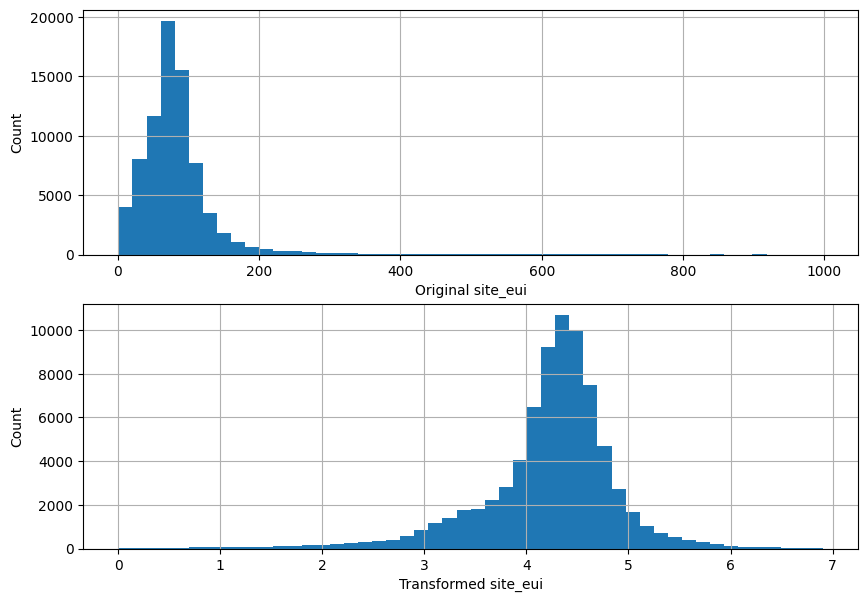

In [46]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

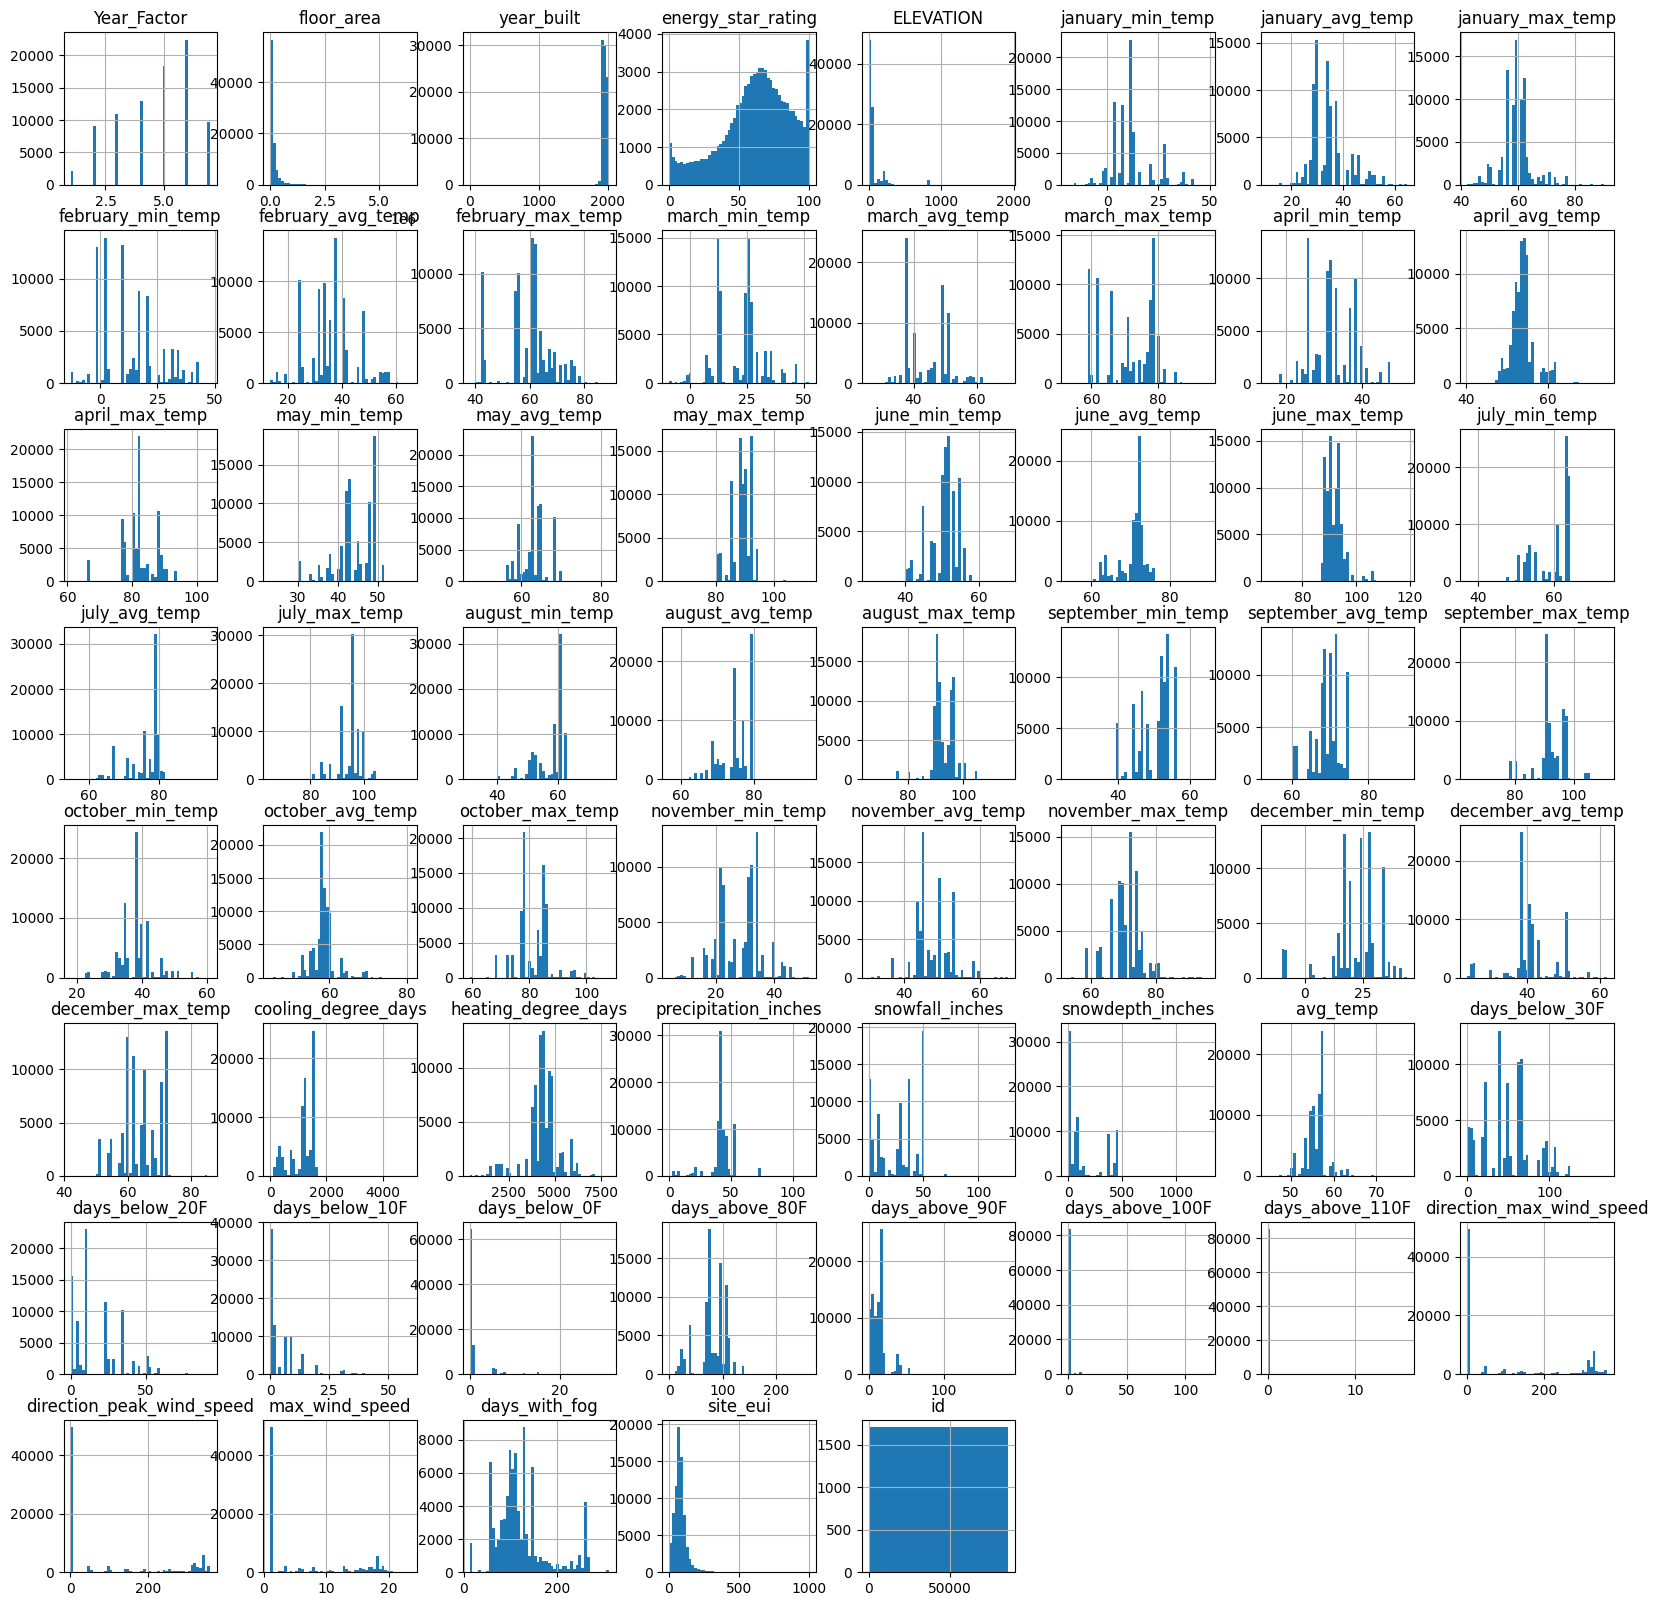

In [47]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [48]:
df_all_te[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.716647
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    Binarize very skewed variables

In [49]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all_te[var] = np.where(df_all_te[var]==0, 0, 1)

### Saving feature dataset

In [50]:
saved = True
if saved:
    import pickle
    data_path = 'data/feature_transformed_set_TEonly.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df_all.to_pickle('data/feature_transformed_set_TEonly.pkl')

In [51]:
df_all_te.shape

(85462, 96)

In [52]:
df_all_te.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,38.428571,45.7,26.0,44.516129,64.0,30.0,49.392857,...,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,0.840888
1,4.0,10149.0,1931.0,43.571429,120.4,41.0,55.096774,73.0,42.0,54.875000,...,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.361889
2,5.0,10149.0,1931.0,37.571429,59.1,29.0,51.387097,77.0,36.0,56.803571,...,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,0.635726
3,7.0,10149.0,1931.0,60.285714,59.1,38.0,50.596774,64.0,40.0,54.482143,...,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.020063
4,3.0,10755.0,1937.0,45.571429,9.1,22.0,44.790323,65.0,25.0,47.892857,...,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,5.007849


# Baseline Modelling

In [53]:
# cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']

# typecasting numerical features
for col in df_all_te.drop(columns=['State_Factor', 'building_class', 'facility_type', 'dataset']).columns:
    df_all_te[col] = df_all_te[col].astype('float64')

In [54]:
df_all_te.shape

(85462, 96)

In [55]:
train = df_all_te[df_all_te['dataset']=='train']
test = df_all_te[df_all_te['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui', 'State_Factor', 'building_class', 'facility_type'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui', 'State_Factor', 'building_class', 'facility_type'], axis=1) #X_test

In [56]:
# State_Factor	building_class	facility_type

In [57]:
y_test = pd.read_csv('data/y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 90)
Test: (9705, 90)
Samples:  (75757,)
Targets:  (9705,)


# Catboost

In [58]:
# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]

In [59]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100
                        )

In [60]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.8499668	test: 61.1900249	best: 61.1900249 (0)	total: 489ms	remaining: 4m 3s
75:	learn: 44.7749826	test: 67.9403189	best: 61.1900249 (0)	total: 27.3s	remaining: 2m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.19002486
bestIteration = 0

Shrink model to first 1 iterations.


In [61]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 61.19002488304389
 MAE: 40.28821550534331
 MSE: 3744.2191451875306
 R2: -0.035551188606074646


# XGBoost

In [62]:
X_train.loc[:,X_train.dtypes=='object'].columns
# State_Factor	building_class	facility_type

Index([], dtype='object')

In [63]:
X_test.loc[:,X_test.dtypes=='object'].columns
# State_Factor	building_class	facility_type

Index([], dtype='object')

In [64]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [65]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 81.64041930202869
 MAE: 54.01089438087214
 MSE: 6665.158063811058
 R2: -0.8434050165301448


# RandomForest

In [66]:
rf = RandomForestRegressor(random_state=1, criterion='friedman_mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [67]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 81.64041930202869
 MAE: 54.01089438087214
 MSE: 6665.158063811058
 R2: -0.8434050165301448


# Lasso Regression

In [68]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.369e+05, tolerance: 2.571e+04


In [69]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 75.58812283911844
 MAE: 50.78517995748607
 MSE: 5713.564314341658
 R2: -0.5802195564590586


# Model Evaluation

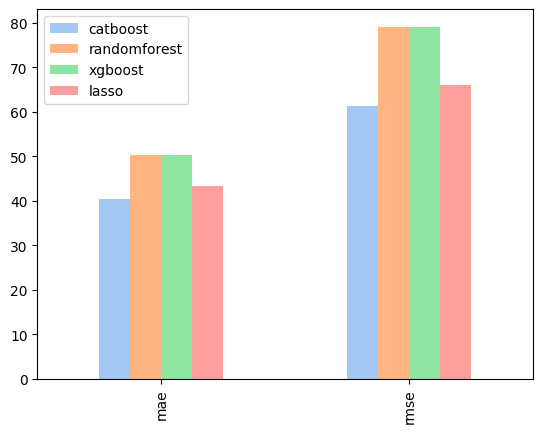

In [70]:
error_rec = {
    "catboost": {
        "mae": 40.29268484855883,
        "rmse": 61.19378120765249,
    },
    "randomforest": {
        "mae": 50.1839889322522,
        "rmse": 79.12972350643851,
    },
    "xgboost": {
         "mae": 50.1839889322522,
        "rmse": 79.12972350643851,
    },
    "lasso": {
         "mae": 43.26164501092259,
        "rmse": 66.08328222674918,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

# Hyperparameter Tunning

# CrossValidation with CatBoost

In [71]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits = NUM_FOLDS, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.0552749	test: 57.0130625	best: 57.0130625 (0)	total: 296ms	remaining: 2m 27s
75:	learn: 45.0366855	test: 45.0131392	best: 45.0131392 (75)	total: 26.2s	remaining: 2m 26s
150:	learn: 42.1003134	test: 43.1290364	best: 43.1290364 (150)	total: 51.4s	remaining: 1m 58s
225:	learn: 40.7189345	test: 42.5334188	best: 42.5334188 (225)	total: 1m 17s	remaining: 1m 33s
300:	learn: 39.7873873	test: 42.2731918	best: 42.2731918 (300)	total: 1m 41s	remaining: 1m 7s
375:	learn: 39.0952809	test: 42.1117844	best: 42.1117844 (375)	total: 2m 8s	remaining: 42.5s
450:	learn: 38.4638494	test: 41.9910451	best: 41.9895425 (449)	total: 2m 34s	remaining: 16.8s
499:	learn: 38.0181865	test: 41.9078214	best: 41.9073564 (497)	total: 2m 50s	remaining: 0us

bestTest = 41.9073564
bestIteration = 497

Shrink model to first 498 iterations.


1it [02:51, 171.82s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.473589142329451


0:	learn: 57.9439348	test: 57.4244150	best: 57.4244150 (0)	total: 385ms	remaining: 3m 12s
75:	learn: 44.9917607	test: 45.5004314	best: 45.5004314 (75)	total: 27.1s	remaining: 2m 31s
150:	learn: 42.0886576	test: 43.5267165	best: 43.5267165 (150)	total: 54.3s	remaining: 2m 5s
225:	learn: 40.7970164	test: 42.9369923	best: 42.9369923 (225)	total: 1m 19s	remaining: 1m 36s
300:	learn: 39.9173292	test: 42.6368893	best: 42.6368893 (300)	total: 1m 46s	remaining: 1m 10s
375:	learn: 39.1830561	test: 42.4343883	best: 42.4343883 (375)	total: 2m 13s	remaining: 44.1s
450:	learn: 38.5640495	test: 42.3005589	best: 42.3005589 (450)	total: 2m 40s	remaining: 17.4s
499:	learn: 38.1962842	test: 42.2188026	best: 42.2188026 (499)	total: 2m 57s	remaining: 0us

bestTest = 42.21880265
bestIteration = 499



2it [05:50, 175.57s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.497599758997306


0:	learn: 57.6761894	test: 58.5649159	best: 58.5649159 (0)	total: 150ms	remaining: 1m 14s
75:	learn: 44.3719745	test: 47.3357835	best: 47.3357835 (75)	total: 26.1s	remaining: 2m 25s
150:	learn: 41.4612832	test: 45.8213380	best: 45.8213380 (150)	total: 49.5s	remaining: 1m 54s
225:	learn: 40.0529218	test: 45.3980461	best: 45.3980461 (225)	total: 1m 11s	remaining: 1m 26s
300:	learn: 39.0755537	test: 45.1958675	best: 45.1958675 (300)	total: 1m 34s	remaining: 1m 2s
375:	learn: 38.3385157	test: 45.0950876	best: 45.0950876 (375)	total: 1m 56s	remaining: 38.6s
450:	learn: 37.7206685	test: 45.0084828	best: 45.0084828 (450)	total: 2m 19s	remaining: 15.2s
499:	learn: 37.3030220	test: 44.9596936	best: 44.9596936 (499)	total: 2m 34s	remaining: 0us

bestTest = 44.95969365
bestIteration = 499



3it [08:24, 165.99s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.705199008644541


0:	learn: 58.4658605	test: 55.3539984	best: 55.3539984 (0)	total: 263ms	remaining: 2m 11s
75:	learn: 45.1616557	test: 43.7469793	best: 43.7469793 (75)	total: 23.1s	remaining: 2m 8s
150:	learn: 42.1210616	test: 42.2208302	best: 42.2208302 (150)	total: 45.8s	remaining: 1m 45s
225:	learn: 40.7089774	test: 41.8585796	best: 41.8585796 (225)	total: 1m 7s	remaining: 1m 22s
300:	learn: 39.8453227	test: 41.7475630	best: 41.7452772 (298)	total: 1m 28s	remaining: 58.7s
375:	learn: 39.1712093	test: 41.6681621	best: 41.6672396 (374)	total: 1m 50s	remaining: 36.5s
450:	learn: 38.5712488	test: 41.6137397	best: 41.6111285 (446)	total: 2m 11s	remaining: 14.3s
499:	learn: 38.2108600	test: 41.5930030	best: 41.5929758 (498)	total: 2m 25s	remaining: 0us

bestTest = 41.59297575
bestIteration = 498

Shrink model to first 499 iterations.


4it [10:50, 158.08s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.449261644758268


0:	learn: 57.0831006	test: 60.8150151	best: 60.8150151 (0)	total: 252ms	remaining: 2m 5s
75:	learn: 44.3316660	test: 48.5934523	best: 48.5934523 (75)	total: 23.5s	remaining: 2m 11s
150:	learn: 41.4601227	test: 46.5733263	best: 46.5733263 (150)	total: 50.8s	remaining: 1m 57s
225:	learn: 40.1558659	test: 45.9088164	best: 45.9088164 (225)	total: 1m 17s	remaining: 1m 33s
300:	learn: 39.3512961	test: 45.6386724	best: 45.6386724 (300)	total: 1m 41s	remaining: 1m 7s
375:	learn: 38.6950210	test: 45.4551374	best: 45.4547716 (374)	total: 2m 6s	remaining: 41.8s
450:	learn: 38.1352027	test: 45.3167531	best: 45.3167531 (450)	total: 2m 31s	remaining: 16.5s
499:	learn: 37.7469281	test: 45.2314285	best: 45.2314285 (499)	total: 2m 47s	remaining: 0us

bestTest = 45.23142846
bestIteration = 499



5it [13:39, 163.99s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.725431462189953


### Using Optuna with Random Forest

In [72]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()



In [73]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [74]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2023-05-16 18:01:51,507] A new study created in memory with name: no-name-8dc03954-2e6f-4f7a-aeb8-0037397f5c0c
[I 2023-05-16 18:15:20,575] Trial 0 finished with value: -43.25187382751618 and parameters: {'n_estimators': 292, 'max_depth': 10, 'min_samples_split': 9, 'max_features': 0.4724651404905151}. Best is trial 0 with value: -43.25187382751618.


Best score: -43.25187382751618
Optimized parameters: {'n_estimators': 292, 'max_depth': 10, 'min_samples_split': 9, 'max_features': 0.4724651404905151}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: total: 11min 16s
Wall time: 13min 29s


In [75]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=0.4724651404905151,
                      min_samples_split=9, n_estimators=292)

# Final Evaluation



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Text(0.5, 0, 'iteration')

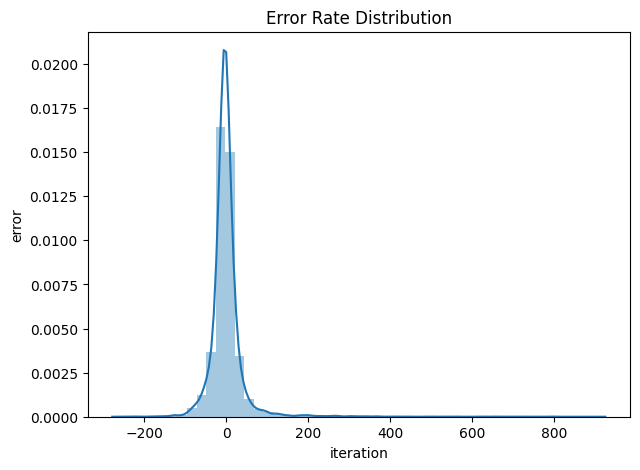

In [76]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Text(0.5, 0, 'iteration')

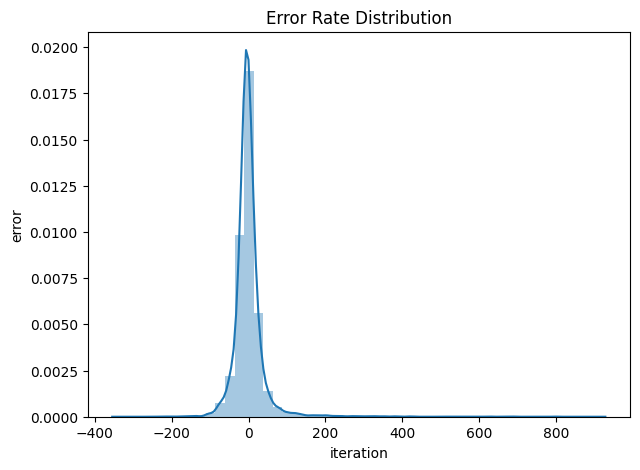

In [77]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

# Saving models

In [78]:
with open('data/rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('data/catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb, f, compress=3)

In [ ]:
## Load models here
load = False
if load:
    with open('data/rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('data/catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)

# Explainable AI

In [79]:
size = 1000

sample_exists = False

if sample_exists:
    sample_set = pd.read_csv('data/shap/sample2000.csv')
else:
    sample_set = X_test.sample(size)
sample_set

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
39323,6.0,55332.0,1950.0,83.000000,42.7,11.0,34.451613,59.0,-1.0,37.706897,...,96.0,34.0,91.0,61.591637,19.839052,0.086495,124.083333,354.333333,2362676.4,1.943794
34088,4.0,74970.0,1900.0,7.000000,42.7,4.0,28.596774,58.0,9.0,31.625000,...,91.0,22.0,92.0,58.740263,20.984169,-0.204013,94.000000,406.250000,3201219.0,0.163934
59155,5.0,111592.0,1910.0,7.000000,15.2,8.0,29.854839,56.0,2.0,23.946429,...,96.0,32.0,97.0,61.920191,21.052041,0.064321,131.750000,371.666667,1696198.4,0.460526
53741,3.0,86434.0,1930.0,65.571429,42.7,11.0,35.080645,61.0,17.0,33.910714,...,98.0,23.0,96.0,59.478913,23.149084,0.108344,106.000000,389.166667,3690731.8,1.535631
22053,2.0,380000.0,1967.0,67.285714,3.4,13.0,37.322581,62.0,20.0,40.879310,...,100.0,31.0,91.0,58.635006,19.428601,0.204298,106.416667,331.500000,1292000.0,19.789916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24287,6.0,95057.0,1963.0,57.571429,3.4,11.0,34.451613,59.0,-1.0,37.706897,...,96.0,34.0,91.0,61.591637,19.839052,0.086495,124.083333,354.333333,323193.8,16.932773
15393,5.0,60885.0,1939.0,76.000000,44.2,8.0,29.966667,49.0,2.0,25.018519,...,95.0,29.0,94.0,60.728380,22.544688,-0.050379,120.916667,361.416667,2691117.0,1.719457
28541,3.0,87016.0,1958.0,60.000000,15.2,11.0,35.080645,61.0,17.0,33.910714,...,98.0,23.0,96.0,59.478913,23.149084,0.108344,106.000000,389.166667,1322643.2,3.947368
18419,6.0,63034.0,1920.0,43.000000,205.7,-4.0,23.350000,48.0,3.0,30.258621,...,92.0,21.0,91.0,58.768519,22.962750,-0.219735,87.916667,468.916667,12966093.8,0.209042


In [80]:
is_saved = False

if is_saved:
    with open('data/shap/shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(rf).shap_values(sample_set)

In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
with open("data/shap_values_sample1000.pkl", "wb") as f:
    pickle.dump(shap_values[0], f)

In [ ]:
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, sample_set)

In [ ]:
limit = 200
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[0:limit,:], sample_set.iloc[0:limit,:])

In [ ]:
row = 60
print(y_pred[row])
shap.initjs()
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[row], sample_set.iloc[row])

In [ ]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

In [ ]:
sample_set.columns

In [ ]:
shap.dependence_plot('te_State_Factor', shap_values, sample_set)

In [ ]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=sample_set.columns.tolist()
                                      )

In [ ]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=sample_set.columns.tolist())

In [ ]:
limit = 500
shap.plots.heatmap(shap.TreeExplainer(rf_tuned_model, data=sample_set)(sample_set[:limit]), max_display=15)